# 21. Уравнение Кеплера

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import brentq

In [32]:
eps = 0.1
M = 24.851090

## 1. Построение орбиты

Движение по эллиптической орбите можно задать параметрически следующим образом: $$ \begin{cases}x(E) = a(cosE-\varepsilon)\\ y(E) = a\sqrt{1-\varepsilon^2}sinE \end{cases}$$

Построим график по точкам:

In [33]:
def draw_orbit():
    E_values = np.linspace(0, 10, 1000)
    a = 5
    eps = 0.1

    def get_x(a, eps, E): return a * (np.cos(E) - eps)
    def get_y(a, eps, E): return a * np.sqrt(1 - eps ** 2) * np.sin(E)

    x_values = get_x(a, eps, E_values)
    y_values = get_y(a, eps, E_values)

    plt.plot(x_values, y_values, '.', markersize=2)
    plt.title(r'Орбита при $\varepsilon = 0.1, a = 5$')
    plt.show()

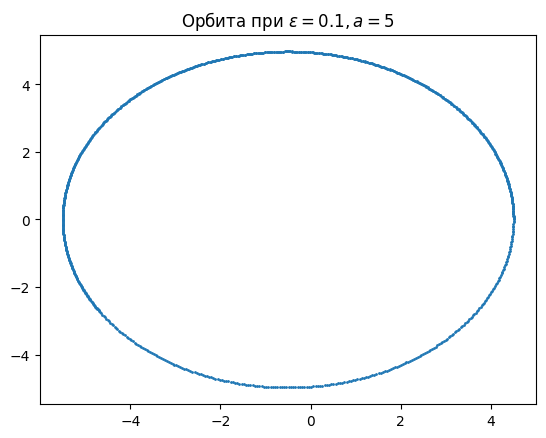

In [34]:
draw_orbit()

## 2. Подготовка к анализу будующих функций

Напишем декоратор для измерения времени работы функций:

In [44]:
from time import perf_counter_ns as time

def get_time(function):
    def wrapped(*args):
        start = time()
        results = function(*args)
        return [results, time() - start]
    return wrapped

## 3. `scipy.optimize.brentq()`

Реализуем вычисление $E$ с помощью функции `scipy.optimize.brentq()`, принимающей на вход функцию и границы промежутка, в рамках которого будет искаться корень. Чтобы оценить, в каком промежутке искать корень, изобразим график при различных $M$:

In [36]:
def draw_eqv():
    M_values = [-1, 0, 1, 2]
    eps = 0.1

    def f(eps, M, E): return E - eps * np.sin(E) - M

    x_values = np.linspace(-3, 3, 100)

    for M in M_values:
        y_values = f(eps, M, x_values)
        plt.plot(x_values, y_values, color='red') 

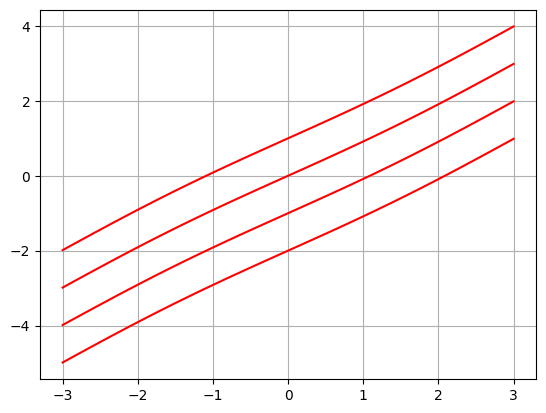

In [42]:
draw_eqv()
plt.grid()
plt.axis('on')
plt.show()

По графику заметим, что при небольших $M$, к коим относится и данное в задаче значение, корень рассматриваемого уравнения будет находится в непосредственной близости с точкой $E_0 = M$. Воспользуемся этим для оптимизации вычислений: 

In [188]:
@get_time
def get_by_brentq(iters):
    def f(x): return x - eps * np.sin(x) - M
    
    return brentq(f, M - 2e-1, M + 2e-1, maxiter=iters)

In [155]:
print("E = %s\nВремя: %s нс" % tuple(get_by_brentq(1000)))

E = 24.820357182542907
Время: 77400 нс


## 4. Формула суммы ряда. Встроенная функция $J_m(x)$

Нам предстоит реализовать функцию для приближенного вычисления суммы ряда. Ее можно было бы реализовать с помощью рекурсии, но это гораздо медленее, чем выполнение простого цикла. Для вычисления $J_m(x)$ воспользуемся функцией `scipy.special.jv()`:

In [97]:
from scipy.special import jv

In [127]:
@get_time
def get_by_bessel_builtin(iters):
    amount = 0.
    for m in range(1, iters + 1):
        amount += jv(m, m * eps) * np.sin(m * M) / m
    return M + 2 * amount

In [130]:
print("E = %s\nВремя: %s нс" % tuple(get_by_bessel_builtin(20)))

E = 24.820357182542907
Время: 210600 нс


## 5. Формула суммы ряда. Собственная реализация $J_m(x)$

Здесь реализация будет в точности такой же, за одним маленьким отличием: мы напишем свою функцию для вычисления $J_m(x)$:

In [150]:
def my_jv(m, e, iters=25):
    amount = 0.
    for n in range(iters):
        amount += ((-1) ** n * (e / 2) ** (2 * n + m)) / (np.math.factorial(n) * np.math.factorial(m + n))
    return amount

@get_time
def get_by_bessel(iters):
    amount = 0.
    for m in range(1, iters + 1):
        amount += my_jv(m, m * eps) * np.sin(m * M) / m
    return M + 2 * amount

In [159]:
print("E = %s\nВремя: %s нс" % tuple(get_by_bessel(100)))

E = 24.820357182542907
Время: 9351400 нс


## 6. Вывод

Чтобы сделать выводы, проведем эксперимент:

In [182]:
def experiment():
    out = "%-25s | %-15s %-25s %-10s"
    print(out % ("Функция", "Итерации", "Результат", "Время"))
    print('=' * 75)
    for iter in [10, 30, 50, 70, 100]:
        for func in [[get_by_brentq, 'get_by_brentq()'], [get_by_bessel_builtin, 'get_by_bessel_builtin()'], [get_by_bessel, 'get_by_bessel()']]:
            result = func[0](iter)
            print(out % tuple([func[1], iter, *result]))
        print('=' * 75)

In [190]:
experiment()

Функция                   | Итерации        Результат                 Время     
get_by_brentq()           | 10              24.820357182542907        74200     
get_by_bessel_builtin()   | 10              24.82035718254295         135500    
get_by_bessel()           | 10              24.82035718254295         761300    
get_by_brentq()           | 30              24.820357182542907        45400     
get_by_bessel_builtin()   | 30              24.820357182542907        261000    
get_by_bessel()           | 30              24.820357182542907        2175900   
get_by_brentq()           | 50              24.820357182542907        40000     
get_by_bessel_builtin()   | 50              24.820357182542907        399100    
get_by_bessel()           | 50              24.820357182542907        4588600   
get_by_brentq()           | 70              24.820357182542907        72100     
get_by_bessel_builtin()   | 70              24.820357182542907        999200    
get_by_bessel()           | 

Как можем заметить по таблице, способ вычисления $E$ с помощью `scipy.optimize.brentq()` гораздо быстрее и гораздо точнее прочих, даже при малом числе итераций. Функция `get_by_bessel_builtin()` показывает несколько худшие результаты: она медленнее первой функции и не совсем точна при малом числе итераций. Функция `get_by_bessel()` никуда не годится в текущей реализации: при большом числе итераций (от двухсот и выше), вычисления переполняют выделенную память и не могут продолжаться, к тому же, его алгоритмическая сложность - около $O(n^2)$, что сказывается на времени выполнения: у этой функции худший временной результат, первосходящий первый способ вычисления не менее, чем в 10 раз, а при числе итераций от 50 до 100 - в 50-200 раз!